In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [5]:
def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
        recovery = (drawdown.loc[end_date[col]:,col])
        try:
            summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
        except:
            summary.loc[col,'Recover'] = pd.to_datetime(None)

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        try:
            summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
        except:
            summary['Duration (to Recover)'] = None
            
        summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

    return summary    

## Exercise - Compensated Risk 
# Question 1

In [12]:
rets = pd.read_excel("spx_returns_weekly.xlsx", sheet_name = "s&p500 rets")
rets = rets.set_index("date")
spy = pd.read_excel("spx_returns_weekly.xlsx", sheet_name = "benchmark rets").set_index("date")[["SPY"]]

In [32]:
means = rets.mean()
skews = rets.skew()
quants = rets.quantile(0.05)
drawdowns = maximumDrawdown(rets)['Max Drawdown']

combined = rets.join(spy)
corrs = combined.corr()['SPY'][:-1]

summary_stats = pd.DataFrame({
    'means' : means,
    'skewness' : skews,
    'quantiles' : quants,
    'drawdowns' : drawdowns,
    'correlation': corrs})
summary_stats    

,means,skewness,quantiles,drawdowns,correlation
A,0.002577,-0.243987,-0.057619,-0.418293,0.689739
AAPL,0.004591,-0.218583,-0.056366,-0.346408,0.687651
ABT,0.002866,-0.256114,-0.052373,-0.330374,0.573112
ACGL,0.003717,0.503618,-0.050282,-0.518036,0.569312
ACN,0.003175,-0.212839,-0.054341,-0.386209,0.730578
...,...,...,...,...,...
XOM,0.001753,-0.068860,-0.054584,-0.597570,0.518788
XYL,0.003107,-0.399871,-0.060031,-0.463902,0.721963
YUM,0.002814,-0.003879,-0.041368,-0.508504,0.639428
ZBH,0.000558,-0.247815,-0.057361,-0.463965,0.614530


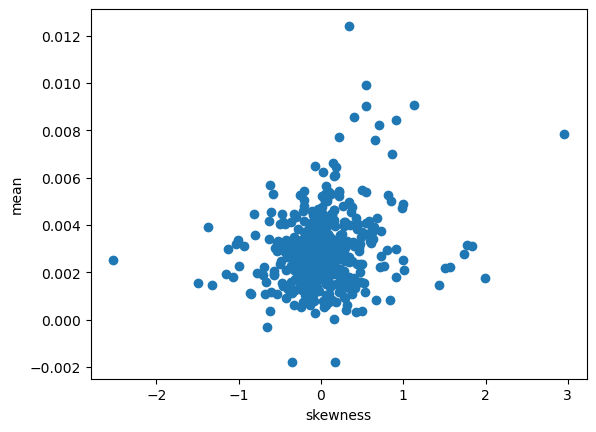

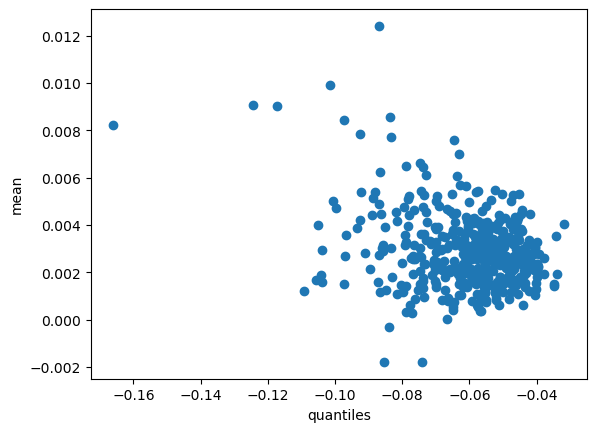

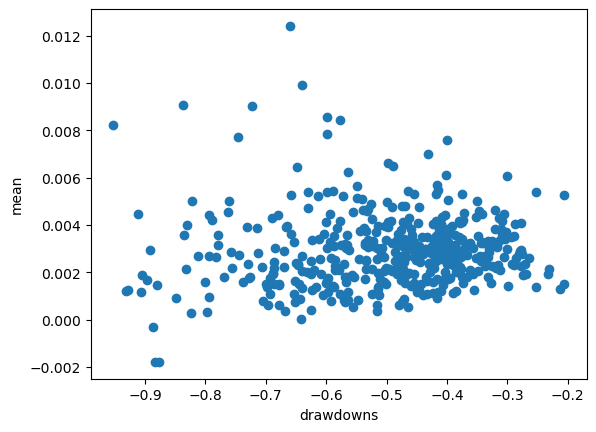

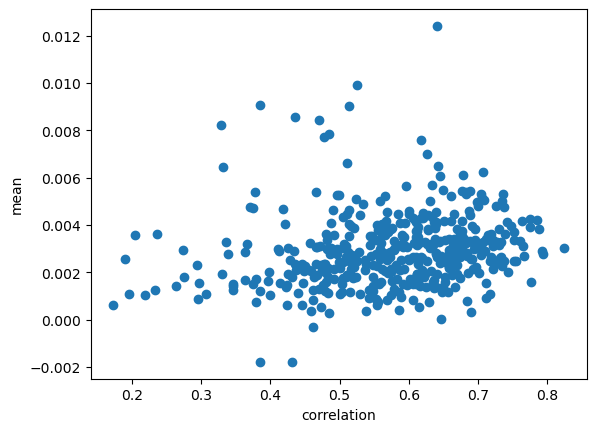

In [36]:
for i in summary_stats.columns[1:]:
    plt.scatter(summary_stats.loc[:,i], summary_stats.iloc[:,0])
    plt.xlabel(i)
    plt.ylabel("mean")
    plt.show()

## Question 2

As disscussed in class there is not a clear relationship between these types of risk and return. The outliers may make some relationship with some of these plots but evenso the relationships will not be strong. It is also worth noting that the correlation with SPY is a multivariate risk statistic instead of univariate. 

## Exercise - Single-Stock Factor Pricing
## Question 1.1

In [46]:
spx_sample = rets.loc[:'2024-12']
mkt = pd.read_excel("factor_pricing_data_weekly.xlsx", sheet_name = "factors (excess returns)").set_index("Date")
mkt_sample = mkt.loc[:'2024-12']

In [56]:
MKT_mean = mkt['MKT'].mean()
combined = spx_sample.join(mkt["MKT"])
MKT_corrs = combined.corr()["MKT"][:-1]
MKT_var = mkt['MKT'].var()

betas = MKT_corrs/MKT_var
print(betas)

sample_risk_premia = spx_sample.mean()
print(sample_risk_premia)

A       1291.244453
AAPL    1249.441633
ABT     1069.333127
ACGL    1052.130780
ACN     1351.758883
           ...     
XOM      952.897593
XYL     1321.090381
YUM     1202.041425
ZBH     1176.512789
ZBRA    1137.310638
Name: MKT, Length: 442, dtype: float64
A       0.003059
AAPL    0.005224
ABT     0.002683
ACGL    0.003850
ACN     0.003529
          ...   
XOM     0.001827
XYL     0.003082
YUM     0.002751
ZBH     0.000819
ZBRA    0.004566
Length: 442, dtype: float64


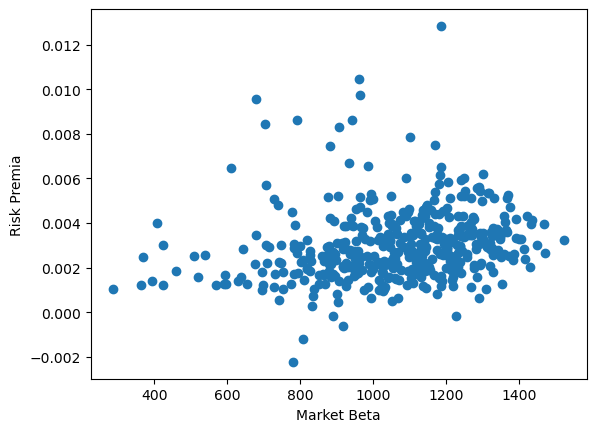

In [57]:
plt.scatter(betas,sample_risk_premia)
plt.xlabel("Market Beta")
plt.ylabel("Risk Premia")
plt.show()

## Question 1.2

In [88]:
def alphas(factors):
    X = sm.add_constant(mkt_sample[factors])
    output = {}

    for i in spx_sample.columns:
        y = data[i]
        model_df = pd.concat([y, X], axis=1).dropna()
        
        model = sm.OLS(model_df[i], model_df[X.columns]).fit()
        output[i] = model.params['const']  # per-period alpha
    return pd.Series(output)

In [89]:
CAPM_alphas = alphas(['MKT'])
FF_alphas = alphas(['MKT', 'SMB', 'HML'])
FOUR_factors = alphas(['MKT','HML','RMW','UMD'])

In [90]:
print(abs(CAPM_alphas).mean()*52)
print(abs(FF_alphas).mean()*52)
print(abs(FOUR_factors).mean()*52)

0.0632045657594632
0.06233486789555173
0.06012588114554267


## Question 1.3

In [91]:
def betas(factors):
    X = sm.add_constant(mkt_sample[factors])
    output = {}

    for i in spx_sample.columns:
        y = data[i]
        model_df = pd.concat([y, X], axis=1).dropna()
        
        model = sm.OLS(model_df[i], model_df[X.columns]).fit()
        output[i] = model.params[factors]  # per-period alpha
    return pd.DataFrame(output).T

In [96]:
CAPM_risk_premia = betas(['MKT'])*np.mean(mkt_sample["MKT"])
FF_risk_premia =betas(['MKT', 'SMB', 'HML']) @ mkt_sample[['MKT', 'SMB', 'HML']].mean()
FOUR_risk_premia = betas(['MKT','HML','RMW','UMD']) @ mkt_sample[['MKT','HML','RMW','UMD']].mean()

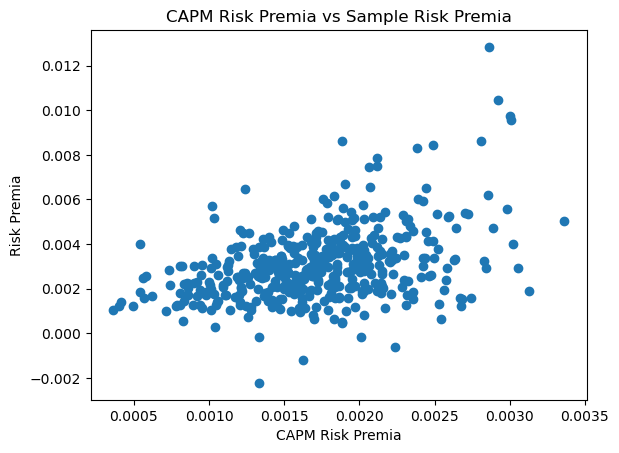

In [97]:
plt.scatter(CAPM_risk_premia,sample_risk_premia)
plt.title("CAPM Risk Premia vs Sample Risk Premia")
plt.xlabel("CAPM Risk Premia")
plt.ylabel("Risk Premia")
plt.show()

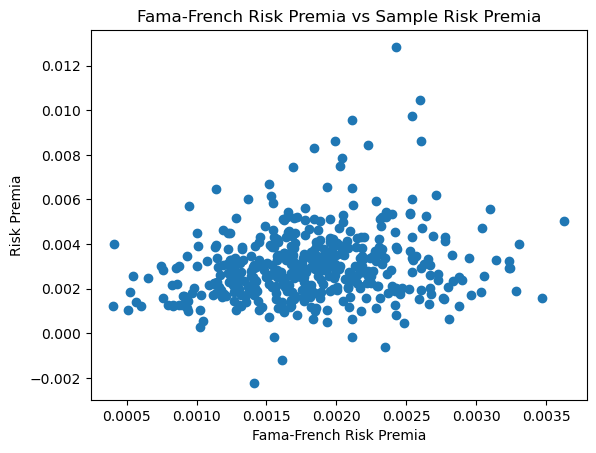

In [98]:
plt.scatter(FF_risk_premia,sample_risk_premia)
plt.title("Fama-French Risk Premia vs Sample Risk Premia")
plt.xlabel("Fama-French Risk Premia")
plt.ylabel("Risk Premia")
plt.show()

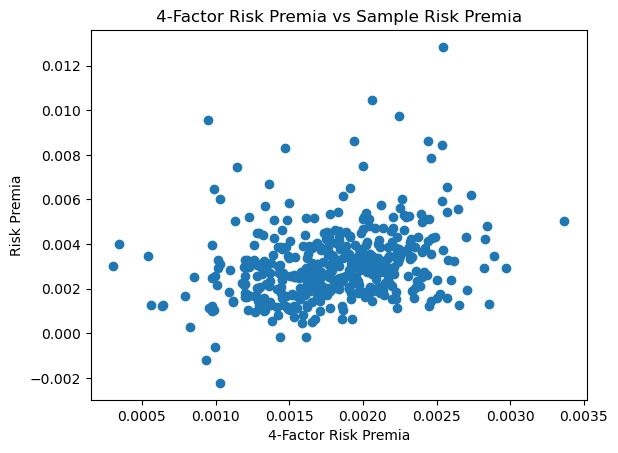

In [100]:
plt.scatter(FOUR_risk_premia,sample_risk_premia)
plt.title("4-Factor Risk Premia vs Sample Risk Premia")
plt.xlabel("4-Factor Risk Premia")
plt.ylabel("Risk Premia")
plt.show()